In [2]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
image_dir = Path('D:\\AIML\\FishImgClassificationProject\\Data\\train')
image_paths= list(image_dir.glob(r'**/*.jpg'))

# Get images and corresponding labels
images = [str(p) for p in image_paths]
labels = [os.path.split(os.path.split(p)[0])[1] for p in image_paths]

df = pd.DataFrame({'Image Path': images,'Label': labels})
print(df['Label'].unique())
print(df)

['animal fish' 'animal fish bass' 'fish sea_food black_sea_sprat'
 'fish sea_food gilt_head_bream' 'fish sea_food hourse_mackerel'
 'fish sea_food red_mullet' 'fish sea_food red_sea_bream'
 'fish sea_food sea_bass' 'fish sea_food shrimp'
 'fish sea_food striped_red_mullet' 'fish sea_food trout']
                                             Image Path                Label
0     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
1     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
2     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
3     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
4     D:\AIML\FishImgClassificationProject\Data\trai...          animal fish
...                                                 ...                  ...
6220  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
6221  D:\AIML\FishImgClassificationProject\Data\trai...  fish sea_food trout
6222  D:\A

In [5]:
df['Label'].value_counts()

Label
animal fish                         1096
fish sea_food trout                  580
fish sea_food red_mullet             579
fish sea_food shrimp                 576
fish sea_food hourse_mackerel        573
fish sea_food red_sea_bream          571
fish sea_food black_sea_sprat        569
fish sea_food gilt_head_bream        566
fish sea_food striped_red_mullet     547
fish sea_food sea_bass               538
animal fish bass                      30
Name: count, dtype: int64

In [ ]:
def plot_history(history):
    """ Plots the graph of Accuracy and Loss over epochs with the history of the model """

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1)) 
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.show()

In [ ]:
# Split the Fish image data into train and test

train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
# Preprocess/Data Augmentation of the train and test data

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Generate the train, validation and test images

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3486 validated image filenames belonging to 11 classes.
Found 871 validated image filenames belonging to 11 classes.
Found 1868 validated image filenames belonging to 11 classes.


In [10]:
print(train_images.image_shape)
print(val_images.image_shape)
print(test_images.image_shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [ ]:
# Load the pretrained MobileNetV2 model

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
# Build the MobileNetV2 model

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the MobileNetV2 model
model.compile(
    optimizer= 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the MobileNetV2 model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)


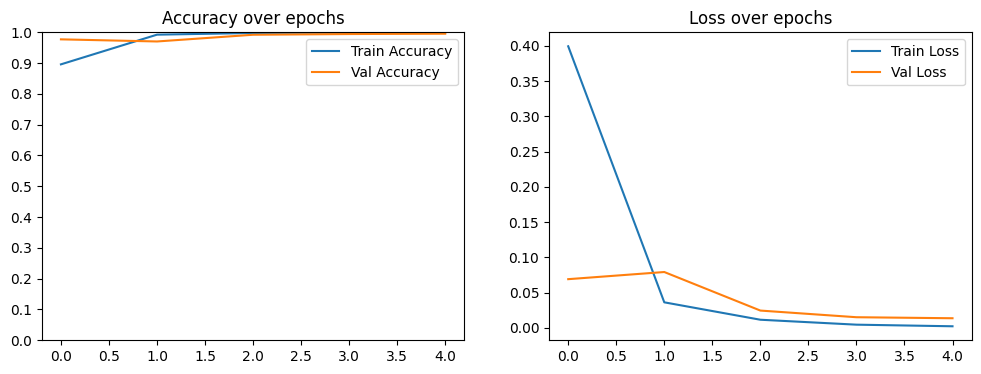

In [ ]:
# Plot graph for Accuracy and Loss over Epochs
plot_history(history)

In [ ]:
# Evaluate the MobileNetV2 model

results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.02373
Test Accuracy: 99.46%


In [ ]:
# Predict and display the metrics of the MobileNetV2 model

prediction_probs = model.predict(test_images)
predictions = np.argmax(prediction_probs, axis=1)

y_true = test_images.classes

print(f"Accuracy: {accuracy_score(y_true, predictions):.4f}")
print(f"Precision: {precision_score(y_true, predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_true, predictions, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_true, predictions, average='weighted'):.4f}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true, predictions)}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 50s 815ms/step
Accuracy: 0.9946
Precision: 0.9946
Recall: 0.9946
F1-Score: 0.9946
Confusion Matrix:
 [[316   1   0   0   0   0   0   0   0   0   0]
 [  2   5   0   0   0   0   0   0   0   0   0]
 [  0   0 175   0   1   0   0   0   0   0   0]
 [  0   0   0 169   0   0   0   0   0   0   1]
 [  0   0   0   0 174   0   0   0   0   1   0]
 [  0   0   0   0   0 171   0   0   0   0   0]
 [  0   0   0   1   0   0 180   0   0   0   0]
 [  0   0   0   0   0   0   0 172   0   0   0]
 [  0   0   0   0   0   0   0   0 170   0   0]
 [  0   0   0   0   0   2   0   1   0 151   0]
 [  0   0   0   0   0   0   0   0   0   0 175]]


In [ ]:
# Save the model as this model has the highest prediction accuracy
model.save("FishImgClass_MobileNetV2.model.h5")